## Feature Generation

Plan: for each day `t`, generate a feature set with:
* [28] Last 14 days of CashIn and CashOut `(t-1)` to `(t-14)`
* [1] Which day of the week? 0 is monday
* [1] Proximity of payday: Offset of the closest payday
* [1] Proximity of payday (absolute): Distance to the closest payday
* [2] Weekday/weekend (one-hot)
* [2] CashIn/CashOut averages of the last week
* [2] CashIn/CashOut averages of the last month

In [1]:
from feature_generation import *

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("DATA_sample_atm.csv")
means = df.groupby("HistoryDate").mean()[['CashIn','CashOut']]
means = means[:-35]
means = clean_data(means)

In [8]:
# input:    dataframe['CashIn', 'CashOut'], date
# do:       generate a feature set for the given date
# return:   return the feature set
def get_feature_sets(df):
    will_merge = [df]

    weekdays = get_day_indexes(df.index)
    will_merge.append(weekdays)

    week_days_one_hot = pd.get_dummies(weekdays, prefix = "Day")    
    will_merge.append(week_days_one_hot)

    # Weekday/weekend (one-hot)
    is_weekday, is_weekend = get_is_weekday_weekend(weekdays)
    will_merge.append(is_weekday)
    will_merge.append(is_weekend)

    # CashIn/CashOut averages of the last week/month
    sizes = [7, 30]
    will_merge.extend(get_average_of_last(df['CashIn'], sizes, "CashIn_average"))
    will_merge.extend(get_average_of_last(df['CashOut'], sizes, "CashOut_average"))

    will_merge.extend(get_distance_to_work_days(df.index))

    # Last 14 days of CashIn and CashOut
    # These windows are actually created twice at the moment. One here and one inside get_average_of_last function
    # We can update to calculate windows only once later.
    cashIn_windows = get_windows(df['CashIn'], 14, "CashIn", drop_t=True)
    cashOut_windows = get_windows(df['CashOut'], 14, "CashOut", drop_t=True)
    will_merge.extend([cashIn_windows, cashOut_windows])

    result = pd.concat(will_merge, axis=1)
    result.dropna(inplace=True)
    
    return result

In [9]:
feature_set = get_feature_sets(means)
feature_set.columns

Index(['CashIn', 'CashOut', 'Day_Index', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Is_Weekday', 'Is_Weekend',
       'CashIn_average_7', 'CashIn_average_30', 'CashOut_average_7',
       'CashOut_average_30', 'curr_month_1_delta', 'curr_month_15_delta',
       'next_month_1_delta', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14'],
      dtype='object')

In [10]:
feature_set.head()

,CashIn,CashOut,Day_Index,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,...,CashOut_t-5,CashOut_t-6,CashOut_t-7,CashOut_t-8,CashOut_t-9,CashOut_t-10,CashOut_t-11,CashOut_t-12,CashOut_t-13,CashOut_t-14
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-01-31,19498.242784,17037.512733,6,0,0,0,0,0,0,1,...,24675.323680,30946.737649,12988.235294,21612.796249,27916.427350,26734.464439,32646.589546,28751.970865,35241.131105,18269.168809
2016-02-01,66313.870968,43221.078098,0,1,0,0,0,0,0,0,...,24231.404255,24675.323680,30946.737649,12988.235294,21612.796249,27916.427350,26734.464439,32646.589546,28751.970865,35241.131105
2016-02-02,43385.920271,36219.117897,1,0,1,0,0,0,0,0,...,22377.232598,24231.404255,24675.323680,30946.737649,12988.235294,21612.796249,27916.427350,26734.464439,32646.589546,28751.970865
2016-02-03,43682.968617,34682.366412,2,0,0,1,0,0,0,0,...,30305.432937,22377.232598,24231.404255,24675.323680,30946.737649,12988.235294,21612.796249,27916.427350,26734.464439,32646.589546
2016-02-04,45025.877863,31624.673452,3,0,0,0,1,0,0,0,...,26373.514431,30305.432937,22377.232598,24231.404255,24675.323680,30946.737649,12988.235294,21612.796249,27916.427350,26734.464439


### Correlation between the generated features:

In [19]:
def correlation(feature_set, correlation_with):
    drop_column = "CashIn" if correlation_with == "CashOut" else "CashOut"
    corrs = feature_set[feature_set.drop(columns=drop_column).columns].corr()

    plt.figure(figsize=(10,10))
    plt.gca().invert_yaxis()

    # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.pcolor(corrs, cmap = "Greens")
    plt.yticks(np.arange(0.5, len(corrs.index), 1), corrs.index)
    plt.xticks(np.arange(0.5, len(corrs.columns), 1), corrs.columns, rotation = 'vertical')
    plt.title("Correlation with " + correlation_with)
    plt.show()

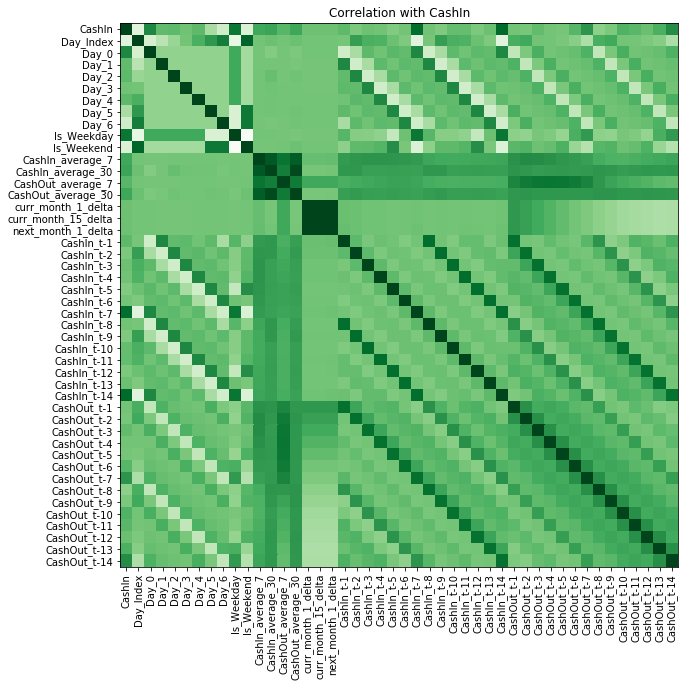

In [20]:
correlation(feature_set, 'CashIn')

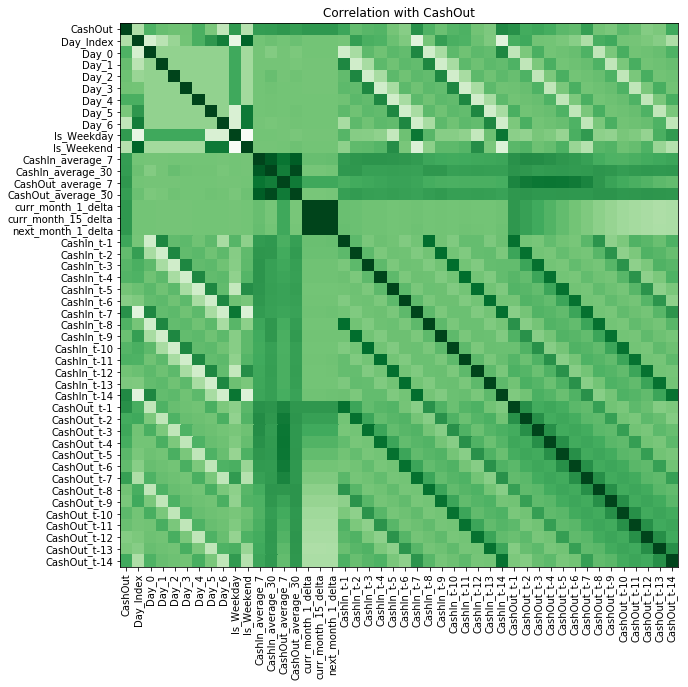

In [21]:
correlation(feature_set, 'CashOut')